In [ ]:
# ============================================================
# 1. CONFIG
# ============================================================
import os
from pathlib import Path

class CFG:
    # ---- Paths ----
    # Change this root if your dataset slug is different on Kaggle
    # Example: Path("/kaggle/input/cpe342-hackathon/task4")
    TASK4_DIR = Path("/kaggle/input/cpe342mlproject/task4")

    TRAIN_CSV = "/kaggle/input/cpe342mlproject/task4/train.csv"
    VAL_CSV   = "/kaggle/input/cpe342mlproject/task4/val.csv"
    TEST_CSV  = "/kaggle/input/cpe342task4refined/test_refined.csv"

    TRAIN_IMG_DIR = TASK4_DIR / "train"
    VAL_IMG_DIR   = TASK4_DIR / "val"
    TEST_IMG_DIR  = TASK4_DIR / "test"

    # If sample_submission.csv is in the root competition folder, point to it here.
    # (OK if this file doesn't exist; we check later.)
    COMP_ROOT      = Path("/")
    SAMPLE_SUB     = COMP_ROOT / "sample_submission.csv"

    # ---- Column names (EDIT IF DIFFERENT) ----
    IMAGE_COL = "file_name"   # image filename column
    LABEL_COL = "label"       # integer class 0–4
    ID_COL    = "id"          # same as in sample_submission.csv
    SUB_TASK4_COL = "task4"   # task 4 column name in sample_submission.csv

    # ---- Training hyperparameters (TUNE HERE) ----
    seed = 42
    debug = False         # True: small subset for quick runs

    img_size = (320, 320) # original images ~230x120, we pad then resize
    batch_size = 64
    num_workers = 0

    epochs = 10
    lr = 2e-4
    weight_decay = 1e-4
    use_scheduler = True

    # ---- Data augmentation ----
    horizontal_flip = True
    color_jitter = True

    # ---- Normalization (ImageNet) ----
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

print("TASK4_DIR:", CFG.TASK4_DIR)


TASK4_DIR: /kaggle/input/cpe342mlproject/task4


In [ ]:
# ============================================================
# 2. IMPORTS
# ============================================================
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
# ============================================================
# 3. UTILS
# ============================================================
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # OK for faster training

set_seed(CFG.seed)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")


In [ ]:
# ============================================================
# 4. LOAD DATA
# ============================================================
train_df = pd.read_csv(CFG.TRAIN_CSV)
val_df   = pd.read_csv(CFG.VAL_CSV)
test_df  = pd.read_csv(CFG.TEST_CSV)

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (31546, 3)
Val shape  : (24772, 3)
Test shape : (25889, 3)


,id,file_name,label
0,PLY00001,su7tkav.jpg,0
1,PLY00002,shlk51f.jpg,4
2,PLY00003,sbdqvs0.jpg,0
3,PLY00004,s6oe1m9.jpg,2
4,PLY00005,skn51jb.jpg,0


Train label distribution:
label
0    12429
1     4407
2     5596
3     5926
4     3188
Name: count, dtype: int64

Val label distribution:
label
0    3436
1    4194
2    6681
3    2912
4    7549
Name: count, dtype: int64

Sample image path: /kaggle/input/cpe342mlproject/task4/train/su7tkav.jpg
Original size (W, H): (230, 120)


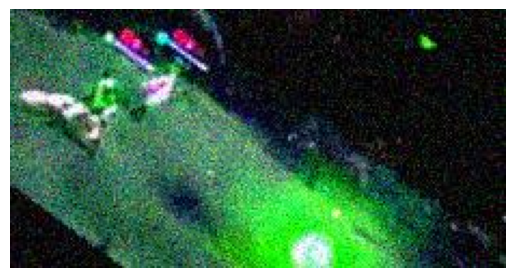

In [ ]:
# ============================================================
# 5. BASIC EDA
# ============================================================
if CFG.LABEL_COL in train_df.columns:
    print("Train label distribution:")
    print(train_df[CFG.LABEL_COL].value_counts().sort_index())

if CFG.LABEL_COL in val_df.columns:
    print("\nVal label distribution:")
    print(val_df[CFG.LABEL_COL].value_counts().sort_index())

# Show one sample image just to verify paths
sample_row = train_df.iloc[0]
sample_path = CFG.TRAIN_IMG_DIR / sample_row[CFG.IMAGE_COL]
print("\nSample image path:", sample_path)

img = Image.open(sample_path).convert("RGB")
print("Original size (W, H):", img.size)  # should be around 230x120
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# ============================================================
# 0. EDA: Load CSV & Basic Structure
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

train_df = pd.read_csv(CFG.TRAIN_CSV)
val_df   = pd.read_csv(CFG.VAL_CSV)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

train_df.head()


Train shape: (31546, 3)
Val shape: (24772, 3)


,id,file_name,label
0,PLY00001,su7tkav.jpg,0
1,PLY00002,shlk51f.jpg,4
2,PLY00003,sbdqvs0.jpg,0
3,PLY00004,s6oe1m9.jpg,2
4,PLY00005,skn51jb.jpg,0


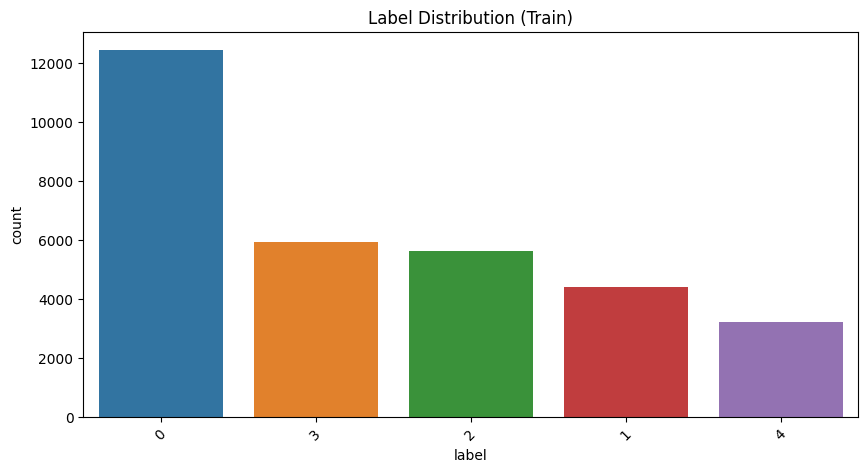

label
0    0.393996
3    0.187853
2    0.177392
1    0.139701
4    0.101059
Name: proportion, dtype: float64

In [ ]:
# ============================================================
# 1. Label Distribution
# ============================================================

plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x="label", order=train_df["label"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Label Distribution (Train)")
plt.show()

train_df["label"].value_counts(normalize=True)


Mean Width: 230.0
Mean Height: 120.0
Unique Sizes: 1


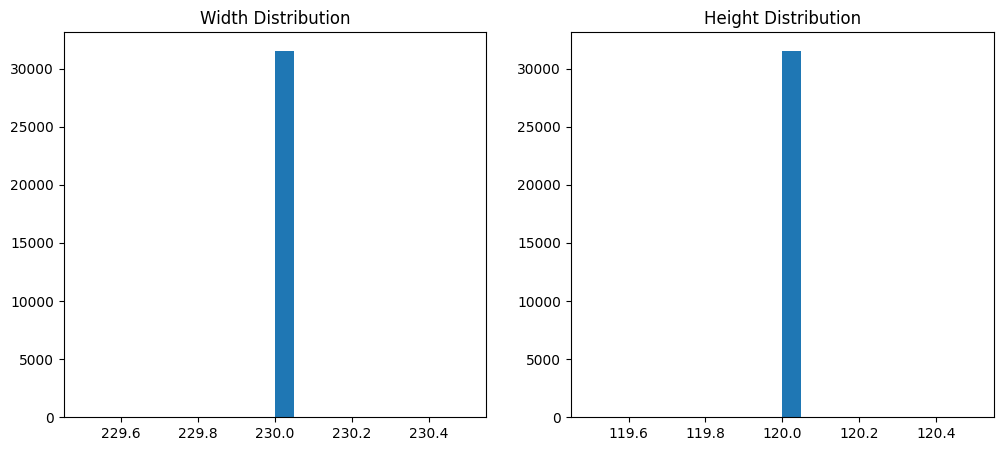

In [ ]:
# ============================================================
# 2. Image Size Exploration
# ============================================================
from PIL import Image
import numpy as np
import cv2

widths, heights = [], []

img_dir = CFG.TASK4_DIR / "train"

for img_name in train_df["file_name"]:
    img_path = img_dir / img_name
    img = Image.open(img_path)
    w, h = img.size
    widths.append(w)
    heights.append(h)

print("Mean Width:", np.mean(widths))
print("Mean Height:", np.mean(heights))
print("Unique Sizes:", len(set(zip(widths, heights))))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=20)
plt.title("Width Distribution")

plt.subplot(1,2,2)
plt.hist(heights, bins=20)
plt.title("Height Distribution")
plt.show()


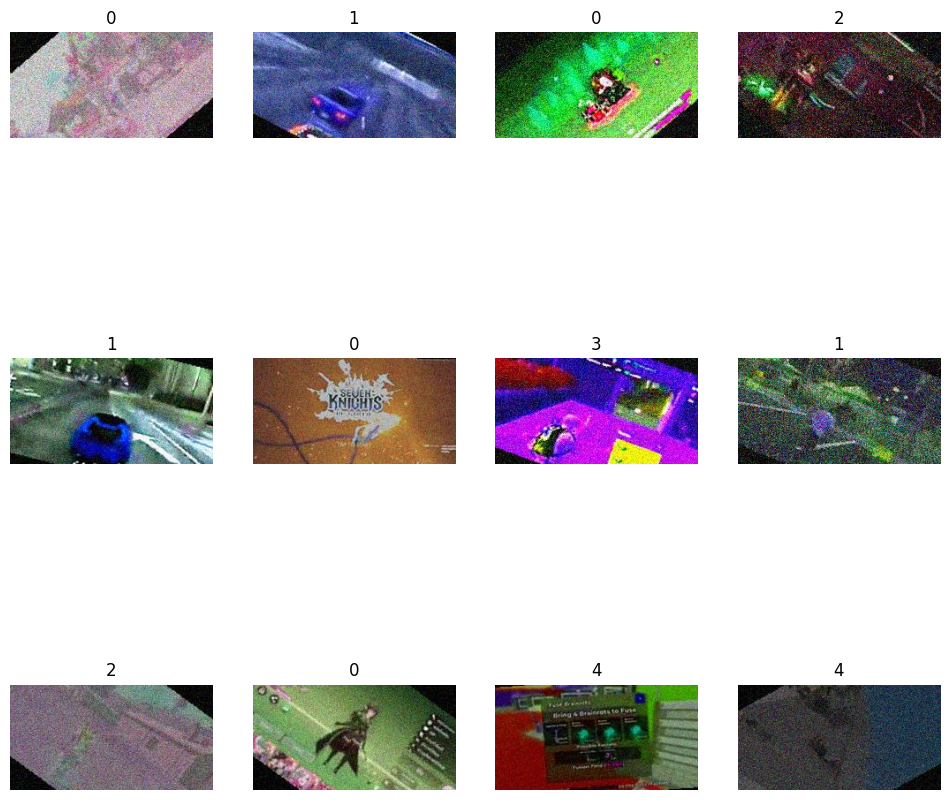

In [ ]:
# ============================================================
# 3. Show Random Raw Samples
# ============================================================
import random

def show_samples(df, n=12):
    sample = df.sample(n)
    plt.figure(figsize=(12,12))
    for i, (_, row) in enumerate(sample.iterrows()):
        img_path = CFG.TASK4_DIR / "train" / row["file_name"]
        img = Image.open(img_path)
        plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(row["label"])
        plt.axis("off")

show_samples(train_df)


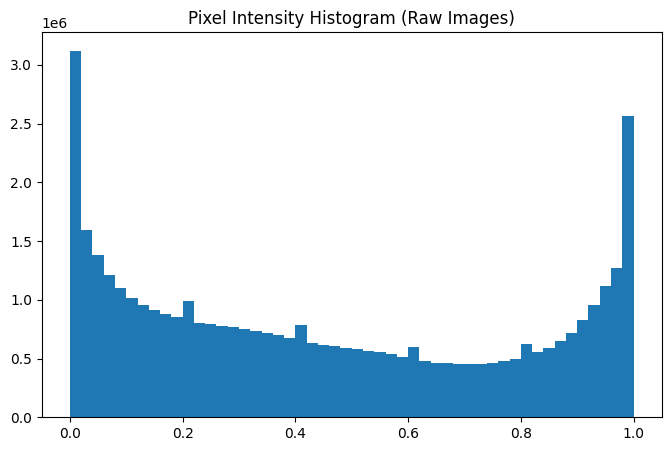

In [ ]:
# ============================================================
# 5. Pixel Intensity Distribution
# ============================================================
import numpy as np

all_pixels = []

for img_name in train_df.sample(500)["file_name"]:  # limit to 500 for speed
    img_path = CFG.TASK4_DIR / "train" / img_name
    img = np.array(Image.open(img_path)).astype("float32") / 255.0
    all_pixels.extend(img.flatten())

plt.figure(figsize=(8,5))
plt.hist(all_pixels, bins=50)
plt.title("Pixel Intensity Histogram (Raw Images)")
plt.show()


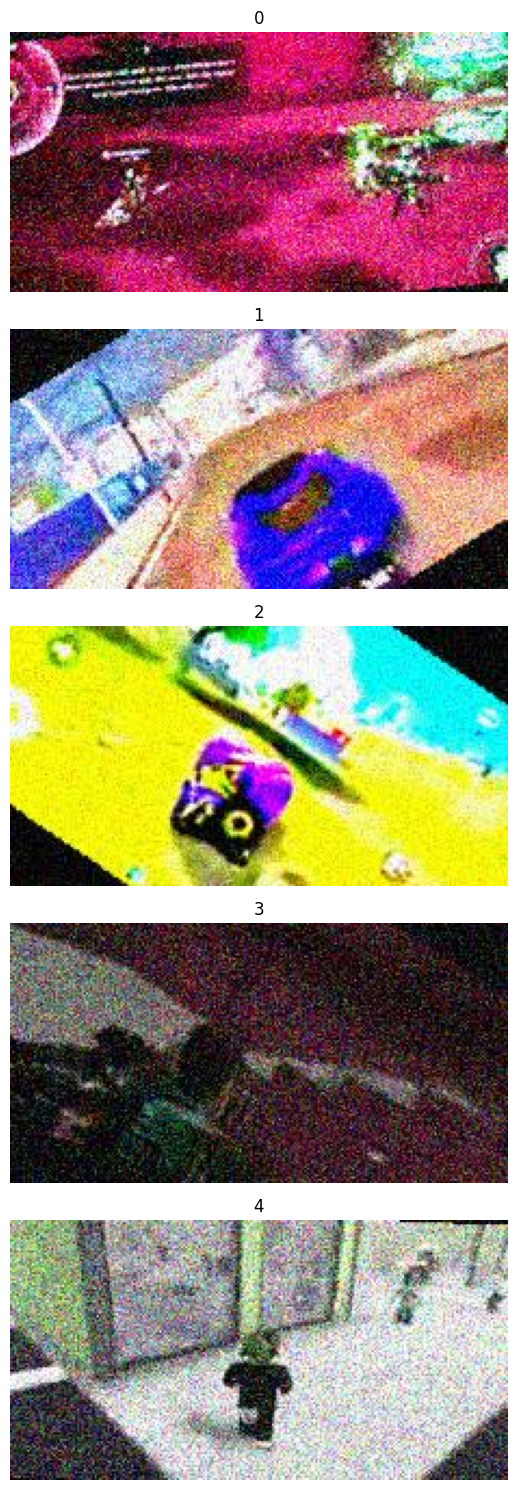

In [ ]:
# ============================================================
# 6. Per-Class Montage (1 sample per label)
# ============================================================
unique_labels = sorted(train_df["label"].unique())

plt.figure(figsize=(12, 3 * len(unique_labels)))

for i, label in enumerate(unique_labels):
    row = train_df[train_df["label"] == label].sample(1).iloc[0]
    img_path = CFG.TASK4_DIR / "train" / row["file_name"]
    img = Image.open(img_path)

    plt.subplot(len(unique_labels), 1, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 6. TRANSFORMS — Optimized for EfficientNetV2-M
# ============================================================
from torchvision.transforms import v2 as T2
from torchvision.transforms import InterpolationMode
from PIL import ImageOps
import torch

# ------------------------------------------------------------
# 1. PadToSquare (UNCHANGED)
# ------------------------------------------------------------
class PadToSquare:
    def __call__(self, img):
        w, h = img.size
        max_side = max(w, h)
        pad_left = (max_side - w) // 2
        pad_top  = (max_side - h) // 2
        padding = (
            pad_left,
            pad_top,
            max_side - w - pad_left,
            max_side - h - pad_top
        )
        return ImageOps.expand(img, padding, fill=0)


# ------------------------------------------------------------
# 2. TRAIN TRANSFORMS — EfficientNetV2-M SAFE AUGMENTATION
# ------------------------------------------------------------
train_transform = T2.Compose([
    PadToSquare(),

    # EfficientNetV2 uses RandomResizedCrop as main augmentation
    T2.RandomResizedCrop(
        size=CFG.img_size,
        scale=(0.7, 1.0),              # safe for screenshots
        ratio=(0.8, 1.25),
        interpolation=InterpolationMode.BICUBIC,
    ),

    # Light color jitter (safe for UI/screenshot dataset)
    T2.ColorJitter(
        brightness=0.12,
        contrast=0.12,
        saturation=0.05,
        hue=0.02
    ),

    # Only safe flip (no rotation — screenshots break easily)
    T2.RandomHorizontalFlip(p=0.25),

    # Very light random erasing (EffNetV2 benefits from it)
    T2.RandomErasing(
        p=0.15,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.0),
        value=0,
    ),

    T2.ToImage(),
    T2.ToDtype(torch.float32, scale=True),
    T2.Normalize(mean=CFG.mean, std=CFG.std),
])


# ------------------------------------------------------------
# 3. VALIDATION TRANSFORM — EfficientNetV2 Inference Style
# ------------------------------------------------------------
val_transform = T2.Compose([
    PadToSquare(),
    T2.Resize(
        CFG.img_size,
        interpolation=InterpolationMode.BICUBIC
    ),
    T2.CenterCrop(CFG.img_size),
    T2.ToImage(),
    T2.ToDtype(torch.float32, scale=True),
    T2.Normalize(mean=CFG.mean, std=CFG.std),
])


In [ ]:
# ============================================================
# 7. DATASET CLASS
# ============================================================
class GameDataset(Dataset):
    def __init__(self, df, img_dir, img_col, label_col=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row[self.img_col]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        if self.label_col is None or self.label_col not in self.df.columns:
            return image

        label = int(row[self.label_col])
        return image, label


In [ ]:
# ============================================================
# 8. DATASETS & DATALOADERS
# ============================================================
# ------------------------------------------------------------
# 8.1. Datasets
# ------------------------------------------------------------
train_dataset = GameDataset(train_df, CFG.TRAIN_IMG_DIR, CFG.IMAGE_COL, CFG.LABEL_COL, train_transform)
val_dataset   = GameDataset(val_df,   CFG.VAL_IMG_DIR,   CFG.IMAGE_COL, CFG.LABEL_COL, val_transform)
test_dataset  = GameDataset(test_df,  CFG.TEST_IMG_DIR,  CFG.IMAGE_COL, label_col=None, transform=val_transform) # No labels for test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size:   {len(val_dataset)}")
print(f"Test dataset size:  {len(test_dataset)}")


# ------------------------------------------------------------
# 8.2. DataLoaders
# ------------------------------------------------------------
train_loader = DataLoader(
    train_dataset, batch_size=CFG.batch_size, shuffle=True,
    num_workers=CFG.num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=CFG.batch_size, shuffle=False,
    num_workers=CFG.num_workers, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=CFG.batch_size, shuffle=False,
    num_workers=CFG.num_workers, pin_memory=True
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batches:   {len(val_loader)}")
print(f"Test loader batches:  {len(test_loader)}")

Train dataset size: 31546
Val dataset size:   24772
Test dataset size:  25889
Train loader batches: 493
Val loader batches:   388
Test loader batches:  405


In [ ]:
# ============================================================
# 9. MODEL — EfficientNet-B4 (ImageNet pretrained)
# ============================================================
from torchvision import models
from torchvision.models import EfficientNet_V2_M_Weights

# Optional flags (only if you haven't already put these in CFG)
if not hasattr(CFG, "use_amp"):
    CFG.use_amp = True          # we'll use this later in the train loop
if not hasattr(CFG, "use_compile"):
    CFG.use_compile = False     # set True if you're on PyTorch 2+ and want torch.compile


def build_model(num_classes: int = 5):
    """
    Build EfficientNet-B4 with ImageNet pretrained weights.
    Head is replaced for our 5-class Task 4.
    """
    weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
    model = models.efficientnet_v2_m(weights=weights)

    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


num_classes = train_df[CFG.LABEL_COL].nunique()
print(f"Num classes: {num_classes}")

model = build_model(num_classes)

# Use channels_last for better GPU perf on conv nets
model = model.to(device)
model = model.to(memory_format=torch.channels_last)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs with DataParallel")
    model = nn.DataParallel(model)


print("Model device:", next(model.parameters()).device)
print("Memory format: channels_last")

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)

# Scheduler
if CFG.use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CFG.epochs
    )
    print("Scheduler: CosineAnnealingLR")
else:
    scheduler = None
    print("Scheduler: None")

# Optional torch.compile (PyTorch 2.x)
if CFG.use_compile and hasattr(torch, "compile"):
    print("Compiling model with torch.compile(...)")
    model = torch.compile(model)
else:
    print("torch.compile not used (set CFG.use_compile = True to enable if supported).")

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params/1e6:.2f}M | Trainable: {trainable_params/1e6:.2f}M")


Num classes: 5


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 194MB/s] 


Model device: cpu
Memory format: channels_last
Scheduler: CosineAnnealingLR
torch.compile not used (set CFG.use_compile = True to enable if supported).
Total params: 52.86M | Trainable: 52.86M


In [ ]:
# ============================================================
# 10. TRAIN & VALIDATION FUNCTIONS (with AMP)
# ============================================================
scaler = torch.cuda.amp.GradScaler(enabled=CFG.use_amp)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    preds_all = []
    targets_all = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True, memory_format=torch.channels_last)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        # ----------- AMP Forward -------------
        with torch.cuda.amp.autocast(enabled=CFG.use_amp):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # ----------- AMP Backward -------------
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1).detach().cpu()
        preds_all.extend(preds.numpy())
        targets_all.extend(targets.cpu().numpy())

    # Compute metrics
    avg_loss = running_loss / len(loader.dataset)
    f1_macro = f1_score(targets_all, preds_all, average="macro")

    return avg_loss, f1_macro


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    preds_all = []
    targets_all = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True, memory_format=torch.channels_last)
        targets = targets.to(device, non_blocking=True)

        # ----------- AMP Inference -------------
        with torch.cuda.amp.autocast(enabled=CFG.use_amp):
            outputs = model(images)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1).detach().cpu()
        preds_all.extend(preds.numpy())
        targets_all.extend(targets.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    f1_macro = f1_score(targets_all, preds_all, average="macro")

    return avg_loss, f1_macro


/tmp/ipykernel_220/3931206730.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.use_amp)


In [ ]:
# ============================================================
# 11 PRO. ADVANCED TRAIN LOOP
# AMP + TQDM + THROUGHOUT + ETA + EARLY STOPPING
# ============================================================
from tqdm import tqdm
import time
import torch

best_f1 = -1.0
best_epoch = -1
no_improve = 0
patience = 5
history = []

best_model_path = "task4_best_efficientnet_b4.pth"

print("🌟 Starting PRO training loop...\n")

def format_time(seconds):
    m = int(seconds // 60)
    s = int(seconds % 60)
    return f"{m}m {s}s"


for epoch in range(1, CFG.epochs + 1):

    print(f"\n==================== EPOCH {epoch}/{CFG.epochs} ====================")

    epoch_start = time.time()

    # -------------------------------------------------------------
    # TRAINING
    # -------------------------------------------------------------
    model.train()
    train_loss_total = 0
    preds_all = []
    targets_all = []

    train_bar = tqdm(
        train_loader,
        desc=f"🚂 Train {epoch}",
        ncols=100,
        leave=False
    )

    for images, targets in train_bar:

        images = images.to(device, non_blocking=True, memory_format=torch.channels_last)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        # AMP forward
        with torch.cuda.amp.autocast(enabled=CFG.use_amp):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # AMP backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm information
        train_loss_total += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        preds_all.extend(preds)
        targets_all.extend(targets.cpu().numpy())

        train_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "GPU Mem": f"{torch.cuda.memory_reserved(0)/1024**2:.0f}MB"
        })

    train_loss = train_loss_total / len(train_dataset)
    train_f1 = f1_score(targets_all, preds_all, average="macro")


    # -------------------------------------------------------------
    # VALIDATION
    # -------------------------------------------------------------
    model.eval()
    val_loss_total = 0
    preds_all = []
    targets_all = []

    val_bar = tqdm(
        val_loader,
        desc=f"🔍 Valid {epoch}",
        ncols=100,
        leave=False
    )

    with torch.no_grad():
        for images, targets in val_bar:

            images = images.to(device, non_blocking=True, memory_format=torch.channels_last)
            targets = targets.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=CFG.use_amp):
                outputs = model(images)
                loss = criterion(outputs, targets)

            val_loss_total += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            preds_all.extend(preds)
            targets_all.extend(targets.cpu().numpy())

            val_bar.set_postfix({
                "v_loss": f"{loss.item():.4f}"
            })

    val_loss = val_loss_total / len(val_dataset)
    val_f1 = f1_score(targets_all, preds_all, average="macro")


    # -------------------------------------------------------------
    # SCHEDULER
    # -------------------------------------------------------------
    if scheduler is not None:
        scheduler.step()


    # -------------------------------------------------------------
    # LOGGING
    # -------------------------------------------------------------
    epoch_time = time.time() - epoch_start
    print(f"EPOCH {epoch} SUMMARY:")
    print(f"  🟢 Train Loss: {train_loss:.4f} | F1: {train_f1:.4f}")
    print(f"  🔵 Val   Loss: {val_loss:.4f} | F1: {val_f1:.4f}")
    print(f"  🕒 Time: {format_time(epoch_time)}")
    print(f"  💾 GPU Memory: {torch.cuda.memory_reserved(0)/1024**2:.0f} MB")
    print("--------------------------------------------------------------")

    # Save history
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_f1": val_f1,
        "epoch_time": epoch_time
    })


    # -------------------------------------------------------------
    # EARLY STOPPING
    # -------------------------------------------------------------
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New BEST model saved! (F1={best_f1:.4f})\n")

    else:
        no_improve += 1
        print(f"  ❌ No improvement ({no_improve}/{patience})")

        if no_improve >= patience:
            print("\n⛔ Early stopping triggered.")
            print(f"Best epoch was {best_epoch} with F1={best_f1:.4f}")
            break


print("\n🎉 Training completed!")
print(f"🥇 Best epoch = {best_epoch}, Best F1 = {best_f1:.4f}")


🌟 Starting PRO training loop...


==================== EPOCH 1/10 ====================


🚂 Train 1:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 1:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 1 SUMMARY:
  🟢 Train Loss: 0.2831 | F1: 0.8870
  🔵 Val   Loss: 0.9628 | F1: 0.7067
  🕒 Time: 53m 12s
  💾 GPU Memory: 976 MB
--------------------------------------------------------------
  ✅ New BEST model saved! (F1=0.7067)


==================== EPOCH 2/10 ====================


🚂 Train 2:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 2:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 2 SUMMARY:
  🟢 Train Loss: 0.0938 | F1: 0.9624
  🔵 Val   Loss: 0.9915 | F1: 0.7133
  🕒 Time: 47m 16s
  💾 GPU Memory: 1010 MB
--------------------------------------------------------------
  ✅ New BEST model saved! (F1=0.7133)


==================== EPOCH 3/10 ====================


🚂 Train 3:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 3:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 3 SUMMARY:
  🟢 Train Loss: 0.0573 | F1: 0.9778
  🔵 Val   Loss: 0.9885 | F1: 0.7436
  🕒 Time: 47m 20s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ✅ New BEST model saved! (F1=0.7436)


==================== EPOCH 4/10 ====================


🚂 Train 4:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 4:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 4 SUMMARY:
  🟢 Train Loss: 0.0408 | F1: 0.9849
  🔵 Val   Loss: 0.8029 | F1: 0.7786
  🕒 Time: 47m 20s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ✅ New BEST model saved! (F1=0.7786)


==================== EPOCH 5/10 ====================


🚂 Train 5:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 5:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 5 SUMMARY:
  🟢 Train Loss: 0.0273 | F1: 0.9895
  🔵 Val   Loss: 1.1417 | F1: 0.7152
  🕒 Time: 47m 19s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ❌ No improvement (1/5)

==================== EPOCH 6/10 ====================


🚂 Train 6:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 6:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 6 SUMMARY:
  🟢 Train Loss: 0.0191 | F1: 0.9931
  🔵 Val   Loss: 0.8801 | F1: 0.7783
  🕒 Time: 47m 29s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ❌ No improvement (2/5)

==================== EPOCH 7/10 ====================


🚂 Train 7:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 7:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 7 SUMMARY:
  🟢 Train Loss: 0.0110 | F1: 0.9958
  🔵 Val   Loss: 0.8113 | F1: 0.7927
  🕒 Time: 47m 24s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ✅ New BEST model saved! (F1=0.7927)


==================== EPOCH 8/10 ====================


🚂 Train 8:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 8:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 8 SUMMARY:
  🟢 Train Loss: 0.0063 | F1: 0.9978
  🔵 Val   Loss: 0.9479 | F1: 0.7870
  🕒 Time: 47m 21s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ❌ No improvement (1/5)

==================== EPOCH 9/10 ====================


🚂 Train 9:   0%|                                                           | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 9:   0%|                                                           | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):


EPOCH 9 SUMMARY:
  🟢 Train Loss: 0.0040 | F1: 0.9986
  🔵 Val   Loss: 0.9419 | F1: 0.7880
  🕒 Time: 47m 23s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ❌ No improvement (2/5)

==================== EPOCH 10/10 ====================


🚂 Train 10:   0%|                                                          | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🔍 Valid 10:   0%|                                                          | 0/388 [00:00<?, ?it/s]/tmp/ipykernel_220/638130408.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
                                                                                                    

EPOCH 10 SUMMARY:
  🟢 Train Loss: 0.0037 | F1: 0.9988
  🔵 Val   Loss: 0.9492 | F1: 0.7885
  🕒 Time: 47m 23s
  💾 GPU Memory: 1004 MB
--------------------------------------------------------------
  ❌ No improvement (3/5)

🎉 Training completed!
🥇 Best epoch = 7, Best F1 = 0.7927


,epoch,train_loss,train_f1,val_loss,val_f1,epoch_time
0,1,0.283148,0.887030,0.962792,0.706727,3192.805881
1,2,0.093771,0.962357,0.991509,0.713316,2836.332341
2,3,0.057316,0.977823,0.988528,0.743618,2840.329901
3,4,0.040764,0.984890,0.802873,0.778590,2840.841709
4,5,0.027340,0.989482,1.141653,0.715227,2839.846859
5,6,0.019067,0.993090,0.880100,0.778306,2849.369790
6,7,0.011013,0.995759,0.811265,0.792711,2844.400194
7,8,0.006273,0.997784,0.947881,0.786979,2841.999949
8,9,0.003960,0.998626,0.941859,0.788042,2843.213694
9,10,0.003726,0.998806,0.949214,0.788456,2843.293524


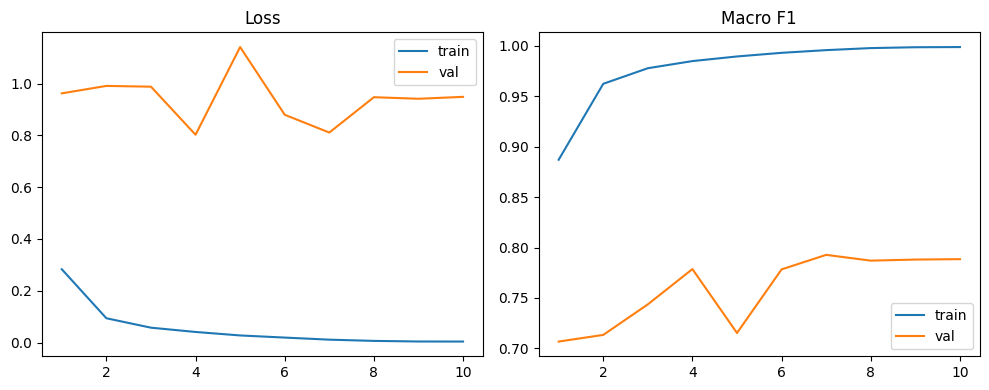

In [ ]:
# ------------------------------------------------------------
# 11.1. Plot training history
# ------------------------------------------------------------
hist_df = pd.DataFrame(history)
display(hist_df)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_df["epoch"], hist_df["train_f1"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_f1"], label="val")
plt.title("Macro F1")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# Ensure CFG has required attributes
# ============================================================
if not hasattr(CFG, "use_amp"):
    CFG.use_amp = True     # or False if you didn't train with AMP

if not hasattr(CFG, "use_compile"):
    CFG.use_compile = False


In [ ]:
# ============================================================
# 12 PRO. INFERENCE + SUBMISSION (EfficientNet-V2-M + AMP + tqdm)
# ============================================================
from tqdm import tqdm
import time
import torch.nn as nn
from torchvision import models
from torchvision.models import EfficientNet_V2_M_Weights
from collections import OrderedDict

# ---------------------------
# Build exact model from training
# ---------------------------
def build_model_for_inference(num_classes):
    weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
    model = models.efficientnet_v2_m(weights=weights)

    # replace classifier head EXACTLY like training
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


# ---------------------------
# Load best model from disk
# ---------------------------
print("🔁 Loading best EfficientNet-V2-M model from disk...")

best_model = build_model_for_inference(num_classes).to(device)
best_model = best_model.to(memory_format=torch.channels_last)

# Load state dict (auto-strip module.)
state = torch.load("task4_best_efficientnet_b4.pth", map_location=device)

new_state = OrderedDict()
for k, v in state.items():
    if k.startswith("module."):
        new_state[k.replace("module.", "")] = v
    else:
        new_state[k] = v

missing = best_model.load_state_dict(new_state, strict=False)
print("⚠ Missing / Unexpected keys:", missing)

best_model.eval()
print("✅ Model loaded and ready for inference.")


# ============================================================
# INFERENCE LOOP
# ============================================================
@torch.no_grad()
def inference_one_epoch_pro(model, loader, device):
    model.eval()
    preds_all = []

    start_time = time.time()
    total_samples = 0

    infer_bar = tqdm(
        loader,
        desc="🧪 Inference",
        ncols=100
    )

    for batch in infer_bar:

        # LazyImageDataset outputs images only
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        images = images.to(device, non_blocking=True, memory_format=torch.channels_last)

        with torch.cuda.amp.autocast(enabled=CFG.use_amp):
            outputs = model(images)
            preds = outputs.argmax(dim=1).detach().cpu().numpy()

        preds_all.extend(preds)
        total_samples += images.size(0)

        elapsed = time.time() - start_time
        ips = total_samples / elapsed if elapsed > 0 else 0.0

        infer_bar.set_postfix({
            "done": total_samples,
            "img/s": f"{ips:.1f}"
        })

    total_time = time.time() - start_time
    return preds_all, total_time


# ---------------------------
# RUN INFERENCE
# ---------------------------
print("\n🚀 Running inference on test set...")
all_preds, infer_time = inference_one_epoch_pro(best_model, test_loader, device)

print(f"\n✅ Inference finished.")
print(f"   Total samples: {len(all_preds)}")
print(f"   Total time: {infer_time:.2f} seconds")
print(f"   Throughput: {len(all_preds) / infer_time:.1f} images/sec")


# ============================================================
# BUILD SUBMISSION
# ============================================================
print("\n📄 Building submission DataFrame...")

submission = pd.DataFrame()
submission["id"] = test_df[CFG.ID_COL].values

if len(submission) != len(all_preds):
    print("⚠ WARNING: test_df length and predictions length differ!")
    print("   len(test_df) =", len(submission), " | len(preds) =", len(all_preds))

    min_len = min(len(submission), len(all_preds))
    submission = submission.iloc[:min_len].copy()
    all_preds = all_preds[:min_len]

submission[CFG.SUB_TASK4_COL] = all_preds

submission_file = "submission_task4_pro.csv"
submission.to_csv(submission_file, index=False)

print(f"✅ Submission saved as: {submission_file}")
print("   Columns:", submission.columns.tolist())
print("   Head:")
print(submission.head())


🔁 Loading best EfficientNet-V2-M model from disk...
⚠ Missing / Unexpected keys: <All keys matched successfully>
✅ Model loaded and ready for inference.

🚀 Running inference on test set...


🧪 Inference:   0%|                                                         | 0/405 [00:00<?, ?it/s]/tmp/ipykernel_220/1394946936.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.use_amp):
🧪 Inference: 100%|███████████████████████| 405/405 [04:36<00:00,  1.47it/s, done=25889, img/s=93.8]


✅ Inference finished.
   Total samples: 25889
   Total time: 276.03 seconds
   Throughput: 93.8 images/sec

📄 Building submission DataFrame...
✅ Submission saved as: submission_task4_pro.csv
   Columns: ['id', 'task4']
   Head:
         id  task4
0  ANS00001      2
1  ANS00002      3
2  ANS00003      3
3  ANS00004      0
4  ANS00005      3


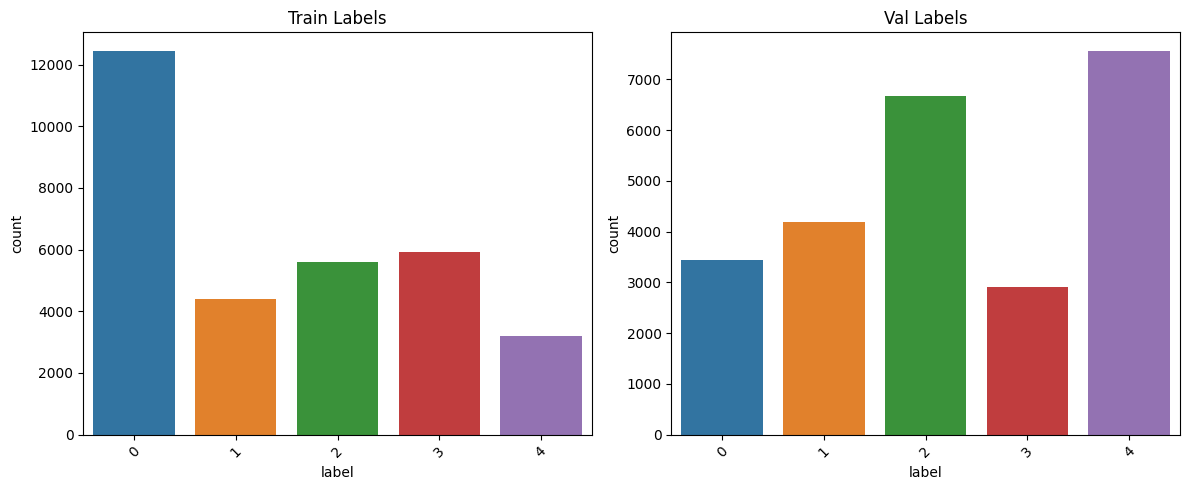

In [ ]:
# ============================================================
# 7. Compare Train vs Val Label Balance
# ============================================================
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.countplot(data=train_df, x="label", ax=ax[0])
ax[0].set_title("Train Labels")
ax[0].tick_params(axis='x', rotation=45)

sns.countplot(data=val_df, x="label", ax=ax[1])
ax[1].set_title("Val Labels")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
